# Introduction

This notebook shows how to use the trained MDN models corresponding to the paper [Machine learning inference of the interior structure of low-mass exoplanets](). 

For further questions, feel free to contact the author:

[Philipp Baumeister](mailto:philipp.baumeister@tu-berlin.de)

# Imports

In [1]:
import numpy as np

import matplotlib.pyplot as plt

import keras
import mdn  # imports the MDN layer
from tensorflow_probability import distributions as tfd
import tensorflow as tf

import joblib

from scipy.stats import norm as normal

from ipywidgets import interactive, widgets
from IPython.display import display, clear_output
m_e = 5.9722e24 # Earth mass
r_e = 6.371e6 # Earth radius

Using TensorFlow backend.


# Functions

In [15]:
def plot_normal_mix(mus, sigmas, alphas, ax, color="b", label='', comp=True):
    """
    Plots the normal mixture to axis=ax
    comp=True plots all components of mixture model
    """
    x = np.linspace(0,1, 250)
    final = np.zeros_like(x)
    for i, (weight_mix, mu_mix, sigma_mix) in enumerate(zip(alphas, mus, sigmas)):
        temp = normal.pdf(x, mu_mix, sigma_mix) * weight_mix
        final = final + temp
        if comp:
            ax.plot(x, temp, color=color, ls=":")
    ax.plot(x, final, label=label, color=color, lw=3)
    return final

def unpack_predictions(prediction, components):
    """ 
    Returns mus, sigs, alphas of predictions.
    """
    return [prediction[:,i*components:(i+1)*components] for i in range(3)]

def get_normal_mix(x, alphas, mus, sigmas):
    """ 
    Returns the normal mixture for an array x and corresponding alphas, mus, sigs.
    """
    final = np.zeros_like(x)
    for i, (weight_mix, mu_mix, sigma_mix) in enumerate(zip(alphas, mus, sigmas)):
        temp = normal.pdf(x, mu_mix, sigma_mix) * weight_mix
        final = final + temp
    return final

def file_parameters(observables):
    use_k2 = observables == "MRk2"
    print(f"Chosen model: {observables}")
    return dict(path=f"./models/{observables}", k2=use_k2)
        
class LoadModelsWidget():
    def __init__(self):
        self.title = widgets.Label("Choose model to load:")
        self.select = widgets.Dropdown(options=[("Mass, radius", "MR"), ("Mass, radius, k2", "MRk2")], description="Observables:")
        self.button = widgets.Button(description="Load model")
        self.button.on_click(self.on_button_clicked)
        self.out = widgets.Output()
        self.vbox = widgets.VBox([self.title, self.select, self.button, self.out])
        self.mdn_model = self.scaler = None 
        self.use_k2 = False
        self.num_components = 20 # number of mixture components
        display(self.vbox)
    
    def on_button_clicked(self, b):
        with self.out:
            clear_output()
            p = file_parameters(self.select.value)
            self.use_k2 = p["k2"]
            self.mdn_model, self.scaler = self.load_model(p["path"])
            
    def load_model(self, path):
        print(f"Loading model {path}_mdn_model.hd5 ...")
        mdn_model = keras.models.load_model(f"{path}_mdn_model.hd5", 
                                            custom_objects={"MDN": mdn.MDN, "loss_func": mdn.get_mixture_loss_func(1, self.num_components)})

        print(f"Loading scaler {path}_scaler.pkl ...")
        scaler = joblib.load(f"{path}_scaler.pkl")
        print("Finished loading models")
        return (mdn_model, scaler)

# Load models

There are two available models to choose from, based on the number of observables they were trained with:
* Mass, radius
* Mass, radius, fluid Love number k<sub>2</sub>

> Note: Loading the MDN model may take up to a minute

In [14]:
model = LoadModelsWidget()

# Predictions

This section shows how to use the model to predict possible interior structures of the Earth based on Earth's mass, radius, and potentially k<sub>2</sub>. 

Inputs need to be scaled using *scaler.transform*. The scaler expects a list of input vectors in the form of `[log10(mass), radius, (k2)]`. Mass and radius are in kg and m, respectively.

Predictions are returned as a list with 4 entries, relating to the core, mantle, ice, and gas envelope of the planet, respectively. Each individual entry contains a list of the predicted mixture parameters for each layer. The first n entries are the means, the second n entries are the std. deviations, the last n entries are the mixing weights (where n is the number of components. The current models all use 20 mixture components). Predictions can be split into their respective means, std. deviations, and alphas using the function `unpack_predictions`.

In [16]:
planet = dict(mass=1, radius=1, k2=0.933)
if model.use_k2:
    input_array = np.array([[np.log10(planet["mass"]*m_e)], [planet["radius"]*r_e], [planet["k2"]]])
else:
    input_array = np.array([[np.log10(planet["mass"]*m_e)], [planet["radius"]*r_e]])
# scale input data to be close to 1
scaled_input = model.scaler.transform(input_array.T)

# let the MDN make the prediction
prediction = model.mdn_model.predict(scaled_input)

# predictions are of the shape (number of interior layers (=4), number of planets, 3*m output nodes (m means, m variances, m weights))
print(np.array(prediction).shape)

(4, 1, 60)


## Plotting predictions

The following code unpacks the prediction for a single planet from above and plots the predicted mixture density for each interior layer. 

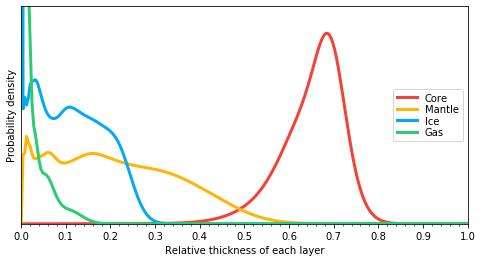

In [17]:
colors = ["#f44336", "#ffb507", "#03a9f4", "#2ecc71"]
predict_label = ["core", "mantle", "ice", "gas"]

fig = plt.figure(figsize=(8,4))
ax = fig.subplots(1, 1)

for j in range(len(prediction)):
    p = predict_label[j]
    mus, sigs, alphas = unpack_predictions(prediction[j], model.num_components)
    pdf = plot_normal_mix(mus[0], sigs[0], alphas[0], ax, label=p.title(), color=colors[j], comp=False)

plt.xlim(0, 1)
plt.ylim(0,8)
ax.set_xticks(np.round(np.linspace(0, 1, 11), 2))
ax.set_xticks(np.round(np.linspace(0, 1, 51), 2), minor=True)
ax.set_yticks([])
ax.set_yticklabels([])

plt.xlabel(r"Relative thickness of each layer")
plt.ylabel(r"Probability density")
plt.legend(labelspacing=0.15, loc="center right")
plt.show()